# Use Keras to recognize hand-written digits with `ibm-watsonx-ai`

This notebook uses the Keras machine learning framework with the Watson Machine Learning service. It contains steps and code to work with [ibm-watsonx-ai](https://pypi.python.org/pypi/ibm-watsonx-ai) library available in PyPI repository. It also introduces commands for getting model and training data, persisting model, deploying model and scoring it.

Some familiarity with Python is helpful. This notebook uses Python 3.11.

## Learning goals

The learning goals of this notebook are:

-  Download an externally trained Keras model with dataset.
-  Persist an external model in Watson Machine Learning repository.
-  Deploy model for online scoring using client library.
-  Score sample records using client library.


## Contents

This notebook contains the following parts:

1.	[Setup](#setup)
2.	[Download externally created Keras model and data](#download)
3.	[Persist externally created Keras model](#upload)
4.	[Deploy and score in a Cloud](#deploy)
5.  [Clean up](#cleanup)
6.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a <a href="https://cloud.ibm.com/catalog/services/watson-machine-learning" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance (a free plan is offered and information about how to create the instance can be found <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/wml-plans.html?context=wx&audience=wdp" target="_blank" rel="noopener no referrer">here</a>).

### Install and import the `ibm-watsonx-ai` and dependecies
**Note:** `ibm-watsonx-ai` documentation can be found <a href="https://ibm.github.io/watsonx-ai-python-sdk/index.html" target="_blank" rel="noopener no referrer">here</a>.

In [ ]:
!pip install wget
!pip install -U ibm-watsonx-ai | tail -n 1

### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud. You need to provide platform `api_key` and instance `location`.

You can use [IBM Cloud CLI](https://cloud.ibm.com/docs/cli/index.html) to retrieve platform API Key and instance location.

API Key can be generated in the following way:
```
ibmcloud login
ibmcloud iam api-key-create API_KEY_NAME
```

In result, get the value of `api_key` from the output.


Location of your WML instance can be retrieved in the following way:
```
ibmcloud login --apikey API_KEY -a https://cloud.ibm.com
ibmcloud resource service-instance WML_INSTANCE_NAME
```

In result, get the value of `location` from the output.

**Tip**: Your `Cloud API key` can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below. You can also get a service specific url by going to the [**Endpoint URLs** section of the Watson Machine Learning docs](https://cloud.ibm.com/apidocs/machine-learning).  You can check your instance location in your  <a href="https://cloud.ibm.com/catalog/services/watson-machine-learning" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance details.

You can also get service specific apikey by going to the [**Service IDs** section of the Cloud Console](https://cloud.ibm.com/iam/serviceids).  From that page, click **Create**, then copy the created key and paste it below.

**Action**: Enter your `api_key` and `location` in the following cell.

In [29]:
api_key = 'PASTE YOUR PLATFORM API KEY HERE'
location = 'PASTE YOUR INSTANCE LOCATION HERE'

In [1]:
from ibm_watsonx_ai import Credentials

credentials = Credentials(
    api_key=api_key,
    url='https://' + location + '.ml.cloud.ibm.com'
)

In [2]:
from ibm_watsonx_ai import APIClient

client = APIClient(credentials)

### Working with spaces

First of all, you need to create a space that will be used for your work. If you do not have space already created, you can use [Deployment Spaces Dashboard](https://dataplatform.cloud.ibm.com/ml-runtime/spaces?context=cpdaas) to create one.

- Click New Deployment Space
- Create an empty space
- Select Cloud Object Storage
- Select Watson Machine Learning instance and press Create
- Copy `space_id` and paste it below

**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: Assign space ID below

In [3]:
space_id = 'PASTE YOUR SPACE ID HERE'

You can use `list` method to print all existing spaces.

In [ ]:
client.spaces.list(limit=10)

To be able to interact with all resources available in Watson Machine Learning, you need to set **space** which you will be using.

In [4]:
client.set.default_space(space_id)

'SUCCESS'

<a id="download"></a>
## 2. Download externally created Keras model and data
In this section, you will download externally created Keras models and data used for training it.

In [5]:
import os
import wget

data_dir = 'MNIST_DATA'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)
    
model_path = os.path.join(data_dir, 'mnist_keras.h5.tgz')
if not os.path.isfile(model_path):
    wget.download("https://github.com/IBM/watson-machine-learning-samples/raw/master/cloud/models/keras/mnist_keras.h5.tgz", out=data_dir)

In [6]:
import os
import wget

data_dir = 'MNIST_DATA'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)
    
filename = os.path.join(data_dir, 'mnist.npz')
if not os.path.isfile(filename):
    wget.download('https://s3.amazonaws.com/img-datasets/mnist.npz', out=data_dir)  

In [7]:
import numpy as np

dataset = np.load(filename)
x_test = dataset['x_test']

<a id="upload"></a>
## 3. Persist externally created Keras model

In this section, you will learn how to store your model in Watson Machine Learning repository by using the Watson Machine Learning Client.

### 3.1: Publish model

#### Publish model in Watson Machine Learning repository on Cloud.

Define model name, type and software specification needed to deploy model later.

In [8]:
sofware_spec_id = client.software_specifications.get_id_by_name("runtime-24.1-py3.11")

In [9]:
metadata = {
            client.repository.ModelMetaNames.NAME: 'External Keras model',
            client.repository.ModelMetaNames.TYPE: 'tensorflow_2.14',
            client.repository.ModelMetaNames.SOFTWARE_SPEC_ID: sofware_spec_id
}

published_model = client.repository.store_model(
    model=model_path,
    meta_props=metadata)

### 3.2: Get model details

In [10]:
import json

published_model_id = client.repository.get_model_id(published_model)
model_details = client.repository.get_details(published_model_id)
print(json.dumps(model_details, indent=2))

{
  "entity": {
    "hybrid_pipeline_software_specs": [],
    "software_spec": {
      "id": "336b29df-e0e1-5e7d-b6a5-f6ab722625b2",
      "name": "runtime-23.1-py3.10"
    },
    "type": "tensorflow_2.12"
  },
  "metadata": {
    "created_at": "2024-03-06T11:27:20.356Z",
    "id": "639e2c14-58a4-4317-8ed8-f569360013ca",
    "modified_at": "2024-03-06T11:27:27.360Z",
    "name": "External Keras model",
    "owner": "IBMid-55000091VC",
    "resource_key": "35e0c562-29bc-4a22-81e2-1f9c370089db",
    "space_id": "93ee84d1-b7dd-42b4-b2ca-121bc0c86315"
  },
  "system": {
    "warnings": []
  }
}


### 3.3 Get all models

In [ ]:
models_details = client.repository.list_models()

<a id="deploy"></a>
## 4. Deploy and score in a Cloud

In this section you will learn how to create online scoring and to score a new data record by using the Watson Machine Learning Client.

### 4.1: Create model deployment

#### Create online deployment for published model

In [12]:
metadata = {
    client.deployments.ConfigurationMetaNames.NAME: "Deployment of external Keras model",
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

created_deployment = client.deployments.create(published_model_id, meta_props=metadata)



#######################################################################################

Synchronous deployment creation for uid: '639e2c14-58a4-4317-8ed8-f569360013ca' started

#######################################################################################


initializing
Note: online_url and serving_urls are deprecated and will be removed in a future release. Use inference instead.
..
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='db0e38bc-e7f8-433a-9d7f-b42e8067da30'
------------------------------------------------------------------------------------------------




**Note**: Here we use deployment url saved in published_model object. In next section, we show how to retrive deployment url from Watson Machine Learning instance.

In [13]:
deployment_id = client.deployments.get_id(created_deployment)

You can also list existing deployments.

In [ ]:
client.deployments.list()

### 4.2: Get deployment details

In [ ]:
client.deployments.get_details(deployment_id)

<a id="score"></a>
### 4.3: Score

You can use below method to do test scoring request against deployed model.

Let's first visualize two samples from dataset, we'll use for scoring.

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

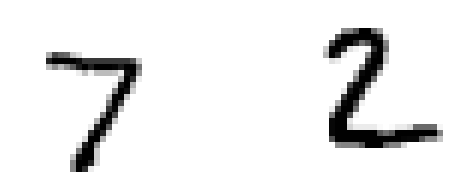

In [17]:
for i, image in enumerate([x_test[0], x_test[1]]):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

Prepare scoring payload with records to score.

In [18]:
score_0 = (x_test[0].ravel() / 255).tolist()
score_1 = (x_test[1].ravel() / 255).tolist()

In [19]:
scoring_payload = {"input_data": [{"values": [score_0, score_1]}]}

Use ``client.deployments.score()`` method to run scoring.

In [20]:
predictions = client.deployments.score(deployment_id, scoring_payload)

In [21]:
print(json.dumps(predictions, indent=2))

{
  "predictions": [
    {
      "id": "dense_2",
      "fields": [
        "prediction",
        "prediction_classes",
        "probability"
      ],
      "values": [
        [
          [
            1.7066226903894588e-12,
            2.6338506375900295e-10,
            2.5274502490901796e-08,
            2.2722660730778443e-07,
            6.751365417244359e-13,
            1.0386839999210196e-10,
            4.863354148457343e-17,
            0.9999995231628418,
            1.871915816797909e-11,
            2.220721739831788e-07
          ],
          7,
          [
            1.7066226903894588e-12,
            2.6338506375900295e-10,
            2.5274502490901796e-08,
            2.2722660730778443e-07,
            6.751365417244359e-13,
            1.0386839999210196e-10,
            4.863354148457343e-17,
            0.9999995231628418,
            1.871915816797909e-11,
            2.220721739831788e-07
          ]
        ],
        [
          [
            9.0352647239

<a id="cleanup"></a>
## 5. Clean up

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
## 6. Summary and next steps

 You successfully completed this notebook! You learned how to use Keras machine learning library as well as Watson Machine Learning for model creation and deployment. Check out our _[Online Documentation](https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/welcome-main.html?context=analytics?pos=2)_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors

**Daniel Ryszka**, Software Engineer

**Mateusz Szewczyk**, Software Engineer at Watson Machine Learning

Copyright © 2020-2024 IBM. This notebook and its source code are released under the terms of the MIT License.